# Compas Data 

Illustration using compas data. Data is available on https://github.com/propublica/compas-analysis

In [1]:
# Adapt this line to suit your need
import os
os.chdir('../')

In [2]:
# Wrangling
import numpy as np
import pandas as pd
import scipy.stats as scs

# Prep
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

# NN
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

# Viz 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [3]:
%load_ext autoreload
%autoreload 2
from main.models.modelarch import SampledMultitask
from main.models.datasamplers import TabularDataSet
from main.calibration.fairness import get_fairness_objects, get_fair_estimation

In [4]:
device_ = torch.device('cpu')

In [5]:
#df_all = pd.read_csv('data/raw/compas/compas-scores-two-years.csv') 
df_all = pd.read_csv('./data/raw/compas/compas-scores-two-years.csv')

In [6]:
# analogous to the original article, remove some observations
df_want = df_all.copy()
df_want = df_want.loc[(df_want.days_b_screening_arrest <= 30), :]
df_want = df_want.loc[(df_want.days_b_screening_arrest >= -30), :]
df_want = df_want.loc[df_want.is_recid != -1, :]
df_want = df_want.loc[df_want.c_charge_degree != 'O', :]
df_want = df_want.loc[~df_want.score_text.isna(), :]

# check shape - should be 6172
df_want.shape

(6172, 53)

In [7]:
df_want['possession_dummy'] = df_want.c_charge_desc.apply(lambda x: 'poss' in str(x).lower())*1
df_want['theft_dummy'] = df_want.c_charge_desc.apply(lambda x: 'theft' in str(x).lower())*1
df_want['driv_dummy'] = df_want.c_charge_desc.apply(lambda x: 'driv' in str(x).lower())*1
df_want['battery_dummy'] = df_want.c_charge_desc.apply(lambda x: 'batt' in str(x).lower())*1
df_want['assault_dummy'] = df_want.c_charge_desc.apply(lambda x: 'assault' in str(x).lower())*1
df_want['weapon_dummy'] = df_want.c_charge_desc.apply(lambda x: 'weap' in str(x).lower())*1
df_want['firearm_dummy'] = df_want.c_charge_desc.apply(lambda x: 'arm' in str(x).lower())*1

df_want.drop(columns='c_charge_desc', inplace=True)

In [8]:
df_features = df_want.drop(columns=['is_violent_recid', 'is_recid'])
df_labels = df_want.loc[:, ['is_recid', 'is_violent_recid']]

In [9]:
remove_features = list(df_want.isna().sum(axis=0)[df_want.isna().sum(axis=0) > 1].index)
remove_features = remove_features + ['two_year_recid', 'event', 'id', 'name', 'first', 'last', 
                                         'compas_screening_date', 'dob', 'c_jail_in', 'c_jail_out', 
                                         'c_case_number', 'type_of_assessment', 'screening_date', 
                                         'v_type_of_assessment', 'v_screening_date', 'in_custody', 
                                         'out_custody', 
                                         'decile_score.1', 'v_decile_score', 'decile_score', 
                                         'score_text', 'v_score_text', 
                                         'priors_count.1', 'start', 'end']

df_features = df_features.loc[:, [col for col in df_features.columns if not col in remove_features]]

In [10]:
other_cols = list(df_features.select_dtypes('object').columns)
numeric_cols = [col_ for col_ in df_features.columns if not col_ in other_cols]

In [11]:
onehot_ = OneHotEncoder()
scaler_ = StandardScaler()

transformer = ColumnTransformer(
    transformers=[('categoricals', onehot_, other_cols), 
                  ('numerical', scaler_, numeric_cols)
                  ], 
                  remainder='passthrough', 
                  sparse_threshold=0)

In [12]:
# Split
X_train, X_test, y_train, y_test = train_test_split(df_features,
                                                    df_labels, 
                                                    test_size=0.2,
                                                    random_state=123)

transformer.fit(X_train)
X_scaled = np.float32(transformer.transform(X_train))
X_test_scaled = np.float32(transformer.transform(X_test))

In [13]:
onehot_enc = OneHotEncoder()

onehot_feats = X_train.loc[:, [col_ for col_ in other_cols]]
onehot_enc.fit(onehot_feats)
transfo_ = onehot_enc.transform(onehot_feats)
onehot_enc.get_feature_names_out()
# sensitive feature is idx 5

array(['sex_Female', 'sex_Male', 'age_cat_25 - 45',
       'age_cat_Greater than 45', 'age_cat_Less than 25',
       'race_African-American', 'race_Asian', 'race_Caucasian',
       'race_Hispanic', 'race_Native American', 'race_Other',
       'c_charge_degree_F', 'c_charge_degree_M'], dtype=object)

In [14]:
data_train = TabularDataSet(X_scaled,
                            np.float32(y_train.iloc[:,0]).reshape(-1,1),
                            np.float32(y_train.iloc[:,1]).reshape(-1,1))
data_test = TabularDataSet(X_test_scaled,
                           np.float32(y_test.iloc[:,0]).reshape(-1,1),
                           np.float32(y_test.iloc[:,1]).reshape(-1,1))

# Dataloaders
trainloader = DataLoader(data_train, batch_size=128, shuffle=True)
testloader = DataLoader(data_test, batch_size=128, shuffle=False)

In [15]:
multitask_model = SampledMultitask(input_dim=27, 
                                   output_1=1, 
                                   sampling_out_1=(0.25, 6),
                                   output_2=1,
                                   sampling_out_2=(0.25, 6),
                                   hidden_layer_architecture=[12,12,12],
                                   device=device_)

In [16]:
%%capture
multitask_model.to(device_)

In [17]:
%%capture
loss_per_iter = []
loss_per_batch = []

optimizer = optim.Adam(multitask_model.parameters(),
                       lr=0.001)

for epoch in range(75):
    print(epoch)
    multitask_model.train(True)
    running_loss = 0.0
    for i, (xval, y1, y2) in enumerate(trainloader):
        xval = xval.to(device_)
        y1 = y1.to(device_)
        y2 = y2.to(device_)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs1, outputs2, lambdas_ = multitask_model(xval.float())
        lambda0 = lambdas_[0].to(device_)
        lambda1 = lambdas_[1].to(device_)

        # need to set loss weights resulting from zero-loss observations to zero        
        loss_fct_binary_task_1 = nn.BCEWithLogitsLoss(weight=lambda0)
        loss_fct_binary_task_2 = nn.BCEWithLogitsLoss(weight=lambda1)

        loss_1 = loss_fct_binary_task_1(outputs1, y1)
        loss_2 = loss_fct_binary_task_2(outputs2, y2)
        
        # Combine losses and get gradient
        loss = loss_1 + loss_2
        loss.backward()
        optimizer.step()

        # Save loss to plot
        running_loss += loss.item()
        loss_per_iter.append(loss.item())

    loss_per_batch.append(running_loss / (i + 1))
    running_loss = 0.0

multitask_model.train(False)

In [18]:
weight_check_1 = 1
weight_check_2 = 4

all_preds_y1 = np.empty((0,1))
all_preds_y2 = np.empty((0,1))
all_true_y1 = np.empty((0,1))
all_true_y2 = np.empty((0,1))


with torch.no_grad():
    for i, (x_test, y1_test, y2_test) in enumerate(testloader):
        
        weight_vector_1 = torch.ones((x_test.shape[0],1))*weight_check_1
        weight_vector_2 = torch.ones((x_test.shape[0],1))*weight_check_2

        test_lambda = [weight_vector_1, weight_vector_2]

        x_test = x_test.to(device_)
        preds_y1, preds_y2 = multitask_model(x_test, param_=test_lambda)

        preds_y1 = torch.sigmoid(preds_y1)
        preds_y2 = torch.sigmoid(preds_y2)

        # attach
        all_preds_y1 = np.concatenate([all_preds_y1, preds_y1.cpu().detach().numpy()])
        all_preds_y2 = np.concatenate([all_preds_y2, preds_y2.cpu().detach().numpy()])

        all_true_y1 = np.concatenate([all_true_y1, y1_test.cpu().detach().numpy()])
        all_true_y2 = np.concatenate([all_true_y2, y2_test.cpu().detach().numpy()])

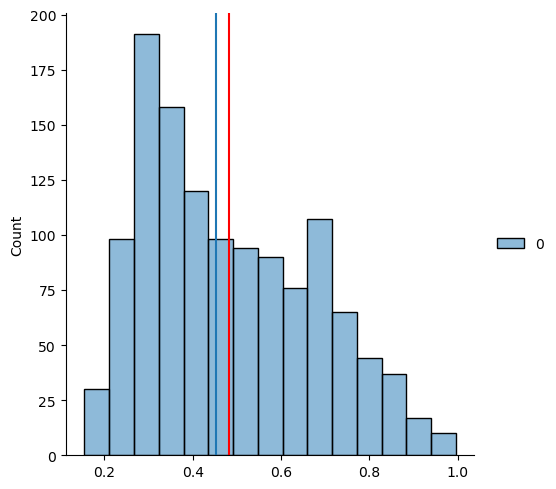

In [19]:
sns.displot(all_preds_y1)
plt.axvline(all_true_y1.mean(), 0,650, label='estimated mean')
plt.axvline(all_preds_y1.mean(), 0,650, color='red', label='true mean')

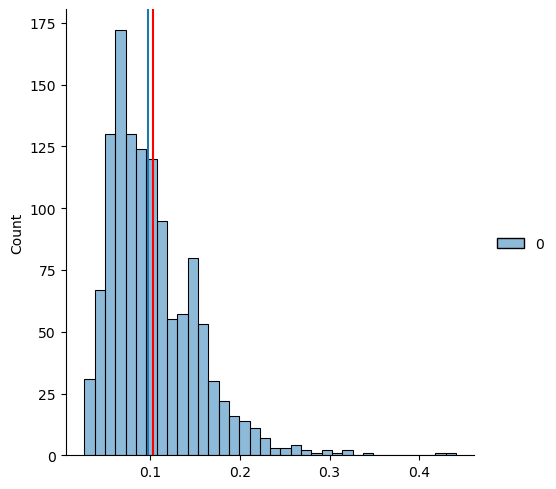

In [20]:
sns.displot(all_preds_y2)
plt.axvline(all_true_y2.mean(), 0,650, label='estimated mean')
plt.axvline(all_preds_y2.mean(), 0,650, color='red', label='true mean')

In [21]:
sensitive_ = X_test_scaled[:,5] == 1.0
sensitive_words = np.where(sensitive_,
                           'Protected', 
                           'Unprotected')

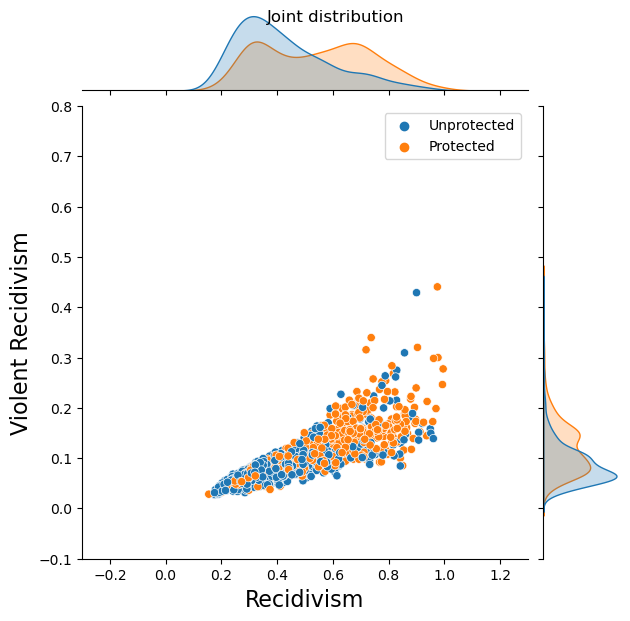

In [22]:
h = sns.jointplot(x=all_preds_y1.reshape(-1,),
                  y=all_preds_y2.reshape(-1,),
                  hue=sensitive_words, 
                  )
h.set_axis_labels('Recidivism',
                  'Violent Recidivism',
                  fontsize=16)

h.ax_marg_x.set_xlim(-0.3, 1.3)
h.ax_marg_y.set_ylim(-0.1, 0.8)

h.fig.suptitle('Joint distribution');

# Get fair predictions

In [23]:
sensitive_test = X_test_scaled[:,5] == 1.0


In [24]:
weight_check_1 = 1
weight_check_2 = 4

sensitive_ = X_scaled[:,5] == 1.0
sensitive_test = X_test_scaled[:,5] == 1.0
sensitive_tensor = torch.from_numpy(X_scaled[sensitive_, :]).to(device_)
nonsensitive_tensor = torch.from_numpy(X_scaled[~sensitive_, :]).to(device_)

# sensitive
weight_vector_1 = torch.ones((sensitive_tensor.shape[0],1))*weight_check_1
weight_vector_2 = torch.ones((sensitive_tensor.shape[0],1))*weight_check_2
weight_vector_1 = weight_vector_1.to(device_)
weight_vector_2 = weight_vector_2.to(device_)
test_lambda = [weight_vector_1, weight_vector_2]

preds_y1_sens, preds_y2_sens = multitask_model(sensitive_tensor, param_=test_lambda)
preds_y1_sens = torch.sigmoid(preds_y1_sens).detach().numpy()
preds_y2_sens = torch.sigmoid(preds_y2_sens).detach().numpy()

# nonsensitive
weight_vector_1 = torch.ones((nonsensitive_tensor.shape[0],1))*weight_check_1
weight_vector_2 = torch.ones((nonsensitive_tensor.shape[0],1))*weight_check_2
weight_vector_1 = weight_vector_1.to(device_)
weight_vector_2 = weight_vector_2.to(device_)
test_lambda = [weight_vector_1, weight_vector_2]

preds_y1_nonsens, preds_y2_nonsens = multitask_model(nonsensitive_tensor, param_=test_lambda)
preds_y1_nonsens = torch.sigmoid(preds_y1_nonsens).detach().numpy()
preds_y2_nonsens = torch.sigmoid(preds_y2_nonsens).detach().numpy()

p1, e1, q1, = get_fairness_objects(sensitive_, 
                                    preds_y1_nonsens, 
                                    preds_y1_sens)

p2, e2, q2, = get_fairness_objects(sensitive_, 
                                    preds_y2_nonsens, 
                                    preds_y2_sens)

# convert to fair estimation 
preds_y1_sens_test = all_preds_y1[sensitive_test]
preds_y1_nonsens_test = all_preds_y1[~sensitive_test]

preds_y2_sens_test = all_preds_y2[sensitive_test]
preds_y2_nonsens_test = all_preds_y2[~sensitive_test]

fair_nonsensitive_y1, fair_sensitive_y1 = get_fair_estimation(p1, e1, q1, 
                                                              preds_y1_nonsens_test.reshape(-1,),
                                                              preds_y1_sens_test.reshape(-1,))

fair_nonsensitive_y2, fair_sensitive_y2 = get_fair_estimation(p2, e2, q2, 
                                                              preds_y2_nonsens_test.reshape(-1,),
                                                              preds_y2_sens_test.reshape(-1,))

fair_vec_1 = np.zeros(shape=(len(sensitive_test), ))
fair_vec_1[~sensitive_test] = fair_nonsensitive_y1
fair_vec_1[sensitive_test] = fair_sensitive_y1

fair_vec_2 = np.zeros(shape=(len(sensitive_test), ))
fair_vec_2[~sensitive_test] = fair_nonsensitive_y2
fair_vec_2[sensitive_test] = fair_sensitive_y2


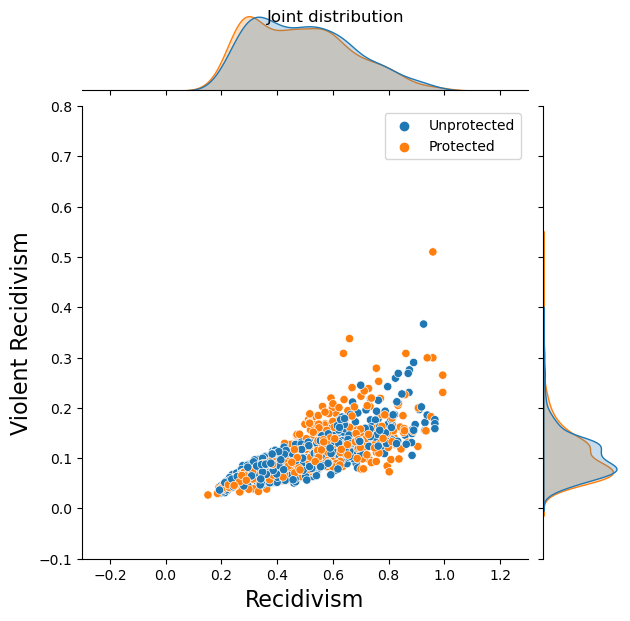

In [25]:
h = sns.jointplot(x=fair_vec_1,
                  y=fair_vec_2,
                  hue=sensitive_words, 
                  )
h.set_axis_labels('Recidivism',
                  'Violent Recidivism',
                  fontsize=16)

h.ax_marg_x.set_xlim(-0.3, 1.3)
h.ax_marg_y.set_ylim(-0.1, 0.8)

h.fig.suptitle('Joint distribution');